### This version without validation and fixed MAP@3 function

In [9]:
import warnings
warnings.filterwarnings('ignore') # to suppress some matplotlib deprecation warnings

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import ast
import cv2

import matplotlib.pyplot as plt
import matplotlib.style as style

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import glob
import time
import tqdm


In [10]:
import apex

In [11]:
git clone https://github.com/NVIDIA/apex.git
python3 apex/setup.py install --cuda_ext --cpp_ext

In [12]:
# !python3 apex/setup.py install --cuda_ext --cpp_ext

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset

import torchvision
from torchvision import transforms, utils

In [14]:
!pwd

/home/jupyter/quickdraw/data


In [15]:
en_dict = {}
path = 'train'

filenames = glob.glob(os.path.join(path, '*.csv'))
filenames = sorted(filenames)

def encode_files():
    """ Encode all label by name of csv_files """
    counter = 0
    for fn in filenames:
        en_dict[fn[:-4].split('/')[-1].replace(' ', '_')] = counter
        counter += 1
        
# collect file names and encode label
encode_files()

dec_dict = {v: k for k, v in en_dict.items()}
def decode_labels(label):
    return dec_dict[label]

def get_label(nfile):
    """ Return encoded label for class by name of csv_files """
    return en_dict[nfile.replace(' ', '_')[:-4]]

In [16]:
class DoodlesDataset(Dataset):
    """Doodles csv dataset."""

    def __init__(self, csv_file, root_dir, mode='train', nrows=1000, skiprows=None, size=256, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            mode (string): Train or test mode.
            nrows (int): Number of rows of file to read. Useful for reading pieces of large files.
            skiprows (list-like or integer or callable): 
                    Line numbers to skip (0-indexed) or number of lines to skip (int) at the start of the file.
            size (int): Size of output image.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        file = os.path.join(self.root_dir, csv_file)
        self.size = size
        self.mode = mode
        self.doodle = pd.read_csv(file, usecols=['drawing'], nrows=nrows, skiprows=skiprows)
        self.transform = transform
        if self.mode == 'train':
            self.label = get_label(csv_file)

    @staticmethod
    def _draw(raw_strokes, size=256, lw=6, time_color=True):
        BASE_SIZE = 256
        img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
        for t, stroke in enumerate(raw_strokes):
            for i in range(len(stroke[0]) - 1):
                color = 255 - min(t, 10) * 13 if time_color else 255
                _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                             (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
        if size != BASE_SIZE:
            return cv2.resize(img, (size, size))
        else:
            return img
    
    def __len__(self):
        return len(self.doodle)

    def __getitem__(self, idx):
        raw_strokes = ast.literal_eval(self.doodle.drawing[idx])
        sample = self._draw(raw_strokes, size=self.size, lw=6, time_color=True)
        if self.transform:
            sample = self.transform(sample)
        if self.mode == 'train':
            return (sample[None]/255).astype('float32'), self.label
        else:
            return (sample[None]/255).astype('float32')

In [17]:
SIZE = 224 # for matching to imagenet
# collect all single csvset in one
select_nrows = 10000
doodle_all = ConcatDataset([DoodlesDataset(fn.split('/')[-1], path, 
                                           nrows=select_nrows, size=SIZE) for fn in filenames])

In [6]:
# select some rows for validation
# valid_rows = 100
# validationset = ConcatDataset([DoodlesDataset(fn.split('/')[-1], path, nrows=valid_rows, size=SIZE,
#                                            skiprows=range(1, select_nrows+1)) for fn in filenames])

In [18]:
# total images in set
print('Train set:', len(doodle_all))
# print('Validation set:', len(validationset))
# Use the torch dataloader to iterate through the dataset
loader = DataLoader(doodle_all, batch_size=128, shuffle=True, num_workers=0)
# valid_loader = DataLoader(validationset, batch_size=128, shuffle=False, num_workers=0)

Train set: 3400000


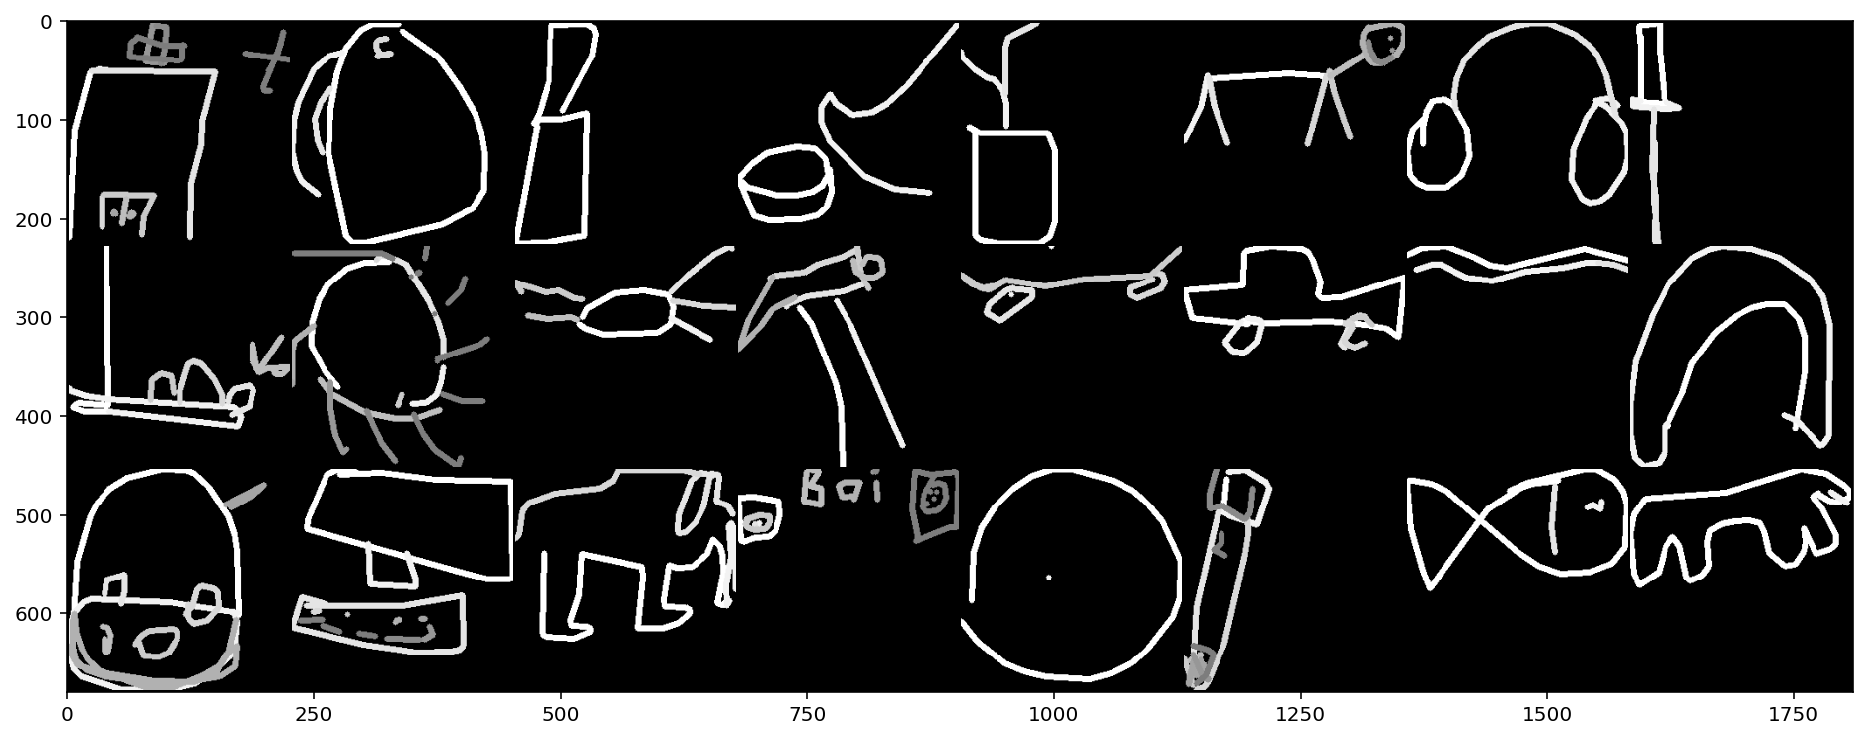

In [19]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some images
dataiter = iter(loader)
images, label = dataiter.next()

# show images
plt.figure(figsize=(16,24))
imshow(torchvision.utils.make_grid(images[:24]))

In [20]:
# validation function 
def validation(lossf, scoref):
    model.eval()
    loss, score = 0, 0
    vlen = len(valid_loader)
    for x, y in valid_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        loss += lossf(output, y).item()
        score += scoref(output, y)[0].item()
    model.train()
    return loss/vlen, score/vlen

In [21]:
def accuracy(output, target, topk=(3,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [22]:
def mapk(output, target, k=3):
    """
    Computes the mean average precision at k.
    
    Parameters
    ----------
    output (torch.Tensor): A Tensor of predicted elements.
                           Shape: (N,C)  where C = number of classes, N = batch size
    target (torch.int): A Tensor of elements that are to be predicted. 
                        Shape: (N) where each value is  0≤targets[i]≤C−1
    k (int, optional): The maximum number of predicted elements
    
    Returns
    -------
    score (torch.float):  The mean average precision at k over the output
    """
    with torch.no_grad():
        batch_size = target.size(0)

        _, pred = output.topk(k, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        for i in range(k):
            correct[i] = correct[i]*(k-i)
            
        score = correct[:k].view(-1).float().sum(0, keepdim=True)
        score.mul_(1.0 / (k * batch_size))
        return score

In [23]:
model = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/jupyter/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 59718198.28it/s]


In [24]:
# Chenge number of inputs channels and number of classes 
# Its first and last layers in model
def squeeze_weights(m):
        m.weight.data = m.weight.data.sum(dim=1)[:,None]
        m.in_channels = 1
        
model.conv1.apply(squeeze_weights);

num_classes = 340
model.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True)

In [25]:
%%time
# test with random data
model(torch.randn(12,1,224,224)).size()

CPU times: user 5.88 s, sys: 736 ms, total: 6.62 s
Wall time: 1.81 s


torch.Size([12, 340])

In [26]:
device = 'cuda'
model.to(device);

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, amsgrad=True)

In [28]:
# PyTorch scheduler:
# https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5000,12000,18000], gamma=0.5)

In [33]:
apex

<module 'apex' (namespace)>

In [18]:
%%time
epochs = 1
lsize = len(loader)
itr = 1
p_itr = 1000 # print every N iteration
model.train()
tloss, score = 0, 0
for epoch in range(epochs):
    for x, y in tqdm.tqdm(loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        tloss += loss.item()
        score += mapk(output, y)[0].item()
        scheduler.step()
        if itr%p_itr==0:
#             vloss, vscore = validation(criterion, mapk)
            print('Iteration {} -> Train Loss: {:.4f}, MAP@3: {:.3f}'.format(itr, tloss/p_itr, score/p_itr))
#             print('Iteration {} -> Validation Loss: {:.4f}, MAP@3: {:.3f}'.format(itr, vloss, vscore))
#             scheduler.step(vscore)
#             time.sleep(0.1)
            tloss, score = 0, 0
        itr +=1
# vloss, vscore = validation(criterion, mapk)
itr = itr%p_itr
print('Final -> Loss: {:.4f}, MAP@3: {:.3f}'.format(loss/itr, score/itr))

  4%|▍         | 1000/26563 [14:51<6:18:42,  1.12it/s]

Iteration 1000 -> Train Loss: 2.3704, MAP@3: 0.565


  8%|▊         | 2000/26563 [29:41<6:05:48,  1.12it/s]

Iteration 2000 -> Train Loss: 1.5653, MAP@3: 0.724


 11%|█▏        | 3000/26563 [44:30<5:49:03,  1.13it/s]

Iteration 3000 -> Train Loss: 1.3869, MAP@3: 0.759


 15%|█▌        | 4000/26563 [59:18<5:32:52,  1.13it/s]

Iteration 4000 -> Train Loss: 1.2896, MAP@3: 0.777


 19%|█▉        | 5000/26563 [1:14:06<5:18:42,  1.13it/s]

Iteration 5000 -> Train Loss: 1.2230, MAP@3: 0.790


 23%|██▎       | 6000/26563 [1:28:53<5:05:11,  1.12it/s]

Iteration 6000 -> Train Loss: 1.0979, MAP@3: 0.815


 26%|██▋       | 7000/26563 [1:43:41<4:49:07,  1.13it/s]

Iteration 7000 -> Train Loss: 1.0673, MAP@3: 0.821


 30%|███       | 8000/26563 [1:58:28<4:35:24,  1.12it/s]

Iteration 8000 -> Train Loss: 1.0539, MAP@3: 0.823


 34%|███▍      | 9000/26563 [2:13:16<4:19:35,  1.13it/s]

Iteration 9000 -> Train Loss: 1.0223, MAP@3: 0.828


 38%|███▊      | 10000/26563 [2:28:04<4:04:03,  1.13it/s]

Iteration 10000 -> Train Loss: 1.0231, MAP@3: 0.829


 41%|████▏     | 11000/26563 [2:42:52<3:49:27,  1.13it/s]

Iteration 11000 -> Train Loss: 1.0068, MAP@3: 0.832


 45%|████▌     | 12000/26563 [2:57:42<3:36:54,  1.12it/s]

Iteration 12000 -> Train Loss: 0.9970, MAP@3: 0.833


 49%|████▉     | 13000/26563 [3:12:32<3:20:55,  1.13it/s]

Iteration 13000 -> Train Loss: 0.9542, MAP@3: 0.842


 53%|█████▎    | 14000/26563 [3:27:23<3:05:22,  1.13it/s]

Iteration 14000 -> Train Loss: 0.9408, MAP@3: 0.843


 56%|█████▋    | 15000/26563 [3:42:09<2:50:32,  1.13it/s]

Iteration 15000 -> Train Loss: 0.9336, MAP@3: 0.846


 60%|██████    | 16000/26563 [3:56:56<2:35:58,  1.13it/s]

Iteration 16000 -> Train Loss: 0.9266, MAP@3: 0.847


 64%|██████▍   | 17000/26563 [4:11:45<2:21:14,  1.13it/s]

Iteration 17000 -> Train Loss: 0.9270, MAP@3: 0.847


 68%|██████▊   | 18000/26563 [4:26:35<2:06:36,  1.13it/s]

Iteration 18000 -> Train Loss: 0.9236, MAP@3: 0.847


 72%|███████▏  | 19000/26563 [4:41:23<1:51:44,  1.13it/s]

Iteration 19000 -> Train Loss: 0.8985, MAP@3: 0.852


 75%|███████▌  | 20000/26563 [4:56:11<1:36:44,  1.13it/s]

Iteration 20000 -> Train Loss: 0.8991, MAP@3: 0.852


 79%|███████▉  | 21000/26563 [5:10:59<1:22:09,  1.13it/s]

Iteration 21000 -> Train Loss: 0.8856, MAP@3: 0.854


 83%|████████▎ | 22000/26563 [5:25:46<1:07:22,  1.13it/s]

Iteration 22000 -> Train Loss: 0.8863, MAP@3: 0.854


 87%|████████▋ | 23000/26563 [5:40:35<52:35,  1.13it/s]  

Iteration 23000 -> Train Loss: 0.8825, MAP@3: 0.855


 90%|█████████ | 24000/26563 [5:55:22<38:01,  1.12it/s]

Iteration 24000 -> Train Loss: 0.8742, MAP@3: 0.856


 94%|█████████▍| 25000/26563 [6:10:09<23:03,  1.13it/s]

Iteration 25000 -> Train Loss: 0.8785, MAP@3: 0.855


 98%|█████████▊| 26000/26563 [6:25:00<08:22,  1.12it/s]

Iteration 26000 -> Train Loss: 0.8804, MAP@3: 0.855


100%|██████████| 26563/26563 [6:33:21<00:00,  1.28it/s]

Final -> Loss: 0.0014, MAP@3: 0.854
CPU times: user 5h 27min 15s, sys: 1h 3min 45s, total: 6h 31min 1s
Wall time: 6h 33min 21s


In [19]:
testset = DoodlesDataset('test_simplified.csv', '../input', mode='test', nrows=None, size=SIZE)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=0)

In [20]:
model.eval()
labels = np.empty((0,3))
for x in tqdm.tqdm(testloader):
    x = x.to(device)
    output = model(x)
    _, pred = output.topk(3, 1, True, True)
    labels = np.concatenate([labels, pred], axis = 0)

100%|██████████| 877/877 [04:52<00:00,  3.38it/s]


In [21]:
%%time
submission = pd.read_csv('../input/test_simplified.csv', index_col='key_id')
submission.drop(['countrycode', 'drawing'], axis=1, inplace=True)
submission['word'] = ''
for i, label in enumerate(labels):
    submission.word.iloc[i] = " ".join([decode_labels(l) for l in label])

CPU times: user 4min 13s, sys: 2.75 s, total: 4min 16s
Wall time: 4min 13s


In [22]:
submission.to_csv('preds_resnet18.csv')

In [25]:
# import the modules we'll need
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)
create_download_link(submission)